In [7]:
import numpy as np
from astropy.io import ascii 
from astropy.table import Table, Column, MaskedColumn
from astropy.io import fits
import os
import os.path
from os import path
import math
#########
import isochrones
from isochrones.mist import MIST_Isochrone
from isochrones.mist.bc import MISTBolometricCorrectionGrid
from isochrones import get_ichrone, SingleStarModel
from isochrones.priors import FlatPrior, PowerLawPrior, GaussianPrior
##########
from IPython.utils import io
from IPython.display import clear_output

In [8]:
Sample = Table.read('/Users/davidnataf/KS_ADAP/FinalSample2023/MP_annex_0.fits')
String = "/Users/davidnataf/KS_ADAP/MP_annex_"
basestring = 'base_MP_annex_0_'
print(np.size(Sample),Sample.colnames,'\n\n')

68177 ['dr3_source_id', 'skymapper_id', 'sdss_id', 'twomass_id', 'allwise_id', 'panstarrs1_id', 'dr2_source_id', 'dr2_gmag', 'dr2_bpmag', 'dr2_rpmag', 'dr2_phot_bp_mean_flux_over_error', 'dr2_phot_g_mean_flux_over_error', 'dr2_phot_rp_mean_flux_over_error', 'solution_id', 'random_index', 'ra2000', 'dec2000', 'ref_epoch', 'ra', 'dec', 'parallax', 'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'phot_g_n_obs', 'phot_g_mean_flux', 'phot_g_mean_flux_error', 'phot_g_mean_flux_over_error', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'phot_bp_mean_flux_over_error', 'phot_rp_mean_flux_over_error', 'phot_variable_flag', 'l', 'b', 'astrometric_excess_noise_sig', 'visibility_periods_used', 'ruwe', 'astrometric_params_solved', 'ipd_gof_harmonic_amplitude', 'nu_eff_used_in_astrometry', 'pseudocolour', 'ecl_lat', 'radial_velocity', 'radial_velocity_error', 'grvs_mag', 'grvs_mag_error', 'rvs_spec_sig_to_noise', 'r_lo_geo', 'r_med_geo', 'r_hi_geo',

In [9]:
Sample['e_gmag_dr2'] = 1.08573620476/Sample['dr2_phot_g_mean_flux_over_error']
Sample['e_bpmag_dr2'] = 1.08573620476/Sample['dr2_phot_bp_mean_flux_over_error']
Sample['e_rpmag_dr2'] = 1.08573620476/Sample['dr2_phot_rp_mean_flux_over_error']
Sample['uSDSSpass'] = np.zeros(np.size(Sample))
Sample['uSDSSpass'][Sample['psfMag_u']> -9999]=1
Sample['gSDSSpass'] = np.zeros(np.size(Sample))
Sample['gSDSSpass'][Sample['psfMag_g']> -9999]=1
Sample['rSDSSpass'] = np.zeros(np.size(Sample))
Sample['rSDSSpass'][Sample['psfMag_r']> -9999]=1
Sample['iSDSSpass'] = np.zeros(np.size(Sample))
Sample['iSDSSpass'][Sample['psfMag_i']> -9999]=1
Sample['zSDSSpass'] = np.zeros(np.size(Sample))
Sample['zSDSSpass'][Sample['psfMag_z']> -9999]=1
#####
Sample['uSMpass'] = np.zeros(np.size(Sample))
Sample['uSMpass'][Sample['u_psf']> -9999]=1
Sample['vSMpass'] = np.zeros(np.size(Sample))
Sample['vSMpass'][Sample['v_psf']> -9999]=1
Sample['gSMpass'] = np.zeros(np.size(Sample))
Sample['gSMpass'][Sample['g_psf']> -9999]=1
Sample['rSMpass'] = np.zeros(np.size(Sample))
Sample['rSMpass'][Sample['r_psf']> -9999]=1
Sample['iSMpass'] = np.zeros(np.size(Sample))
Sample['iSMpass'][Sample['i_psf']> -9999]=1
Sample['zSMpass'] = np.zeros(np.size(Sample))
Sample['zSMpass'][Sample['z_psf']> -9999]=1
#####
Sample['PS_gpass'] = np.zeros(np.size(Sample))
Sample['PS_gpass'][Sample['gMeanPSFMag']> -9999]=1
Sample['PS_rpass'] = np.zeros(np.size(Sample))
Sample['PS_rpass'][Sample['rMeanPSFMag']> -9999]=1
Sample['PS_ipass'] = np.zeros(np.size(Sample))
Sample['PS_ipass'][Sample['iMeanPSFMag']> -9999]=1
Sample['PS_zpass'] = np.zeros(np.size(Sample))
Sample['PS_zpass'][Sample['zMeanPSFMag']> -9999]=1
Sample['PS_ypass'] = np.zeros(np.size(Sample))
Sample['PS_ypass'][Sample['yMeanPSFMag']> -9999]=1
#######
Sample['FUVpass'] = np.zeros(np.size(Sample))
Sample['FUVpass'][Sample['FUVmag']> -9999]=1
Sample['NUVpass'] = np.zeros(np.size(Sample))
Sample['NUVpass'][Sample['NUVmag']> -9999]=1
########
Sample['BPpass'] = np.zeros(np.size(Sample))
Sample['BPpass'][Sample['dr2_bpmag']>-9999]=1
Sample['RPpass'] = np.zeros(np.size(Sample))
Sample['RPpass'][Sample['dr2_rpmag']>-9999]=1
UsedPS1 = np.zeros(np.size(Sample))


for i1,k1 in enumerate(Sample['dr3_source_id']):    
    if ((Sample['uSDSSpass'][i1]==1) & (Sample['uSMpass'][i1]==1)):
        Sample['uSMpass'][i1]=0
    sumSDSS = Sample['gSDSSpass'][i1]+Sample['rSDSSpass'][i1]+\
    Sample['iSDSSpass'][i1]+Sample['zSDSSpass'][i1]
    sumSM = Sample['gSMpass'][i1]+\
    Sample['rSMpass'][i1]+Sample['iSMpass'][i1]+Sample['zSMpass'][i1]
    SumPS1 = Sample['PS_gpass'][i1]+Sample['PS_rpass'][i1]+\
    Sample['PS_ipass'][i1]+Sample['PS_zpass'][i1]
    SumGaia = Sample['RPpass'][i1]+Sample['RPpass'][i1]
    MaxSum=np.max([sumSDSS,sumSM,SumPS1,SumGaia])
    if (SumPS1==MaxSum):
        Sample['BPpass'][i1]=0
        Sample['RPpass'][i1]=0
        Sample['gSDSSpass'][i1]=0
        Sample['rSDSSpass'][i1]=0
        Sample['iSDSSpass'][i1]=0
        Sample['zSDSSpass'][i1]=0
        Sample['gSMpass'][i1]=0
        Sample['rSMpass'][i1]=0
        Sample['iSMpass'][i1]=0
        Sample['zSMpass'][i1]=0
    elif (sumSDSS==MaxSum):
        Sample['BPpass'][i1]=0
        Sample['RPpass'][i1]=0
        Sample['PS_gpass'][i1]=0
        Sample['PS_rpass'][i1]=0
        Sample['PS_ipass'][i1]=0
        Sample['PS_zpass'][i1]=0
        Sample['gSMpass'][i1]=0
        Sample['rSMpass'][i1]=0
        Sample['iSMpass'][i1]=0
        Sample['zSMpass'][i1]=0
    elif (sumSM==MaxSum):
        Sample['BPpass'][i1]=0
        Sample['RPpass'][i1]=0
        Sample['PS_gpass'][i1]=0
        Sample['PS_rpass'][i1]=0
        Sample['PS_ipass'][i1]=0
        Sample['PS_zpass'][i1]=0
        Sample['gSDSSpass'][i1]=0
        Sample['rSDSSpass'][i1]=0
        Sample['iSDSSpass'][i1]=0
        Sample['zSDSSpass'][i1]=0
    else:
        Sample['PS_gpass'][i1]=0
        Sample['PS_rpass'][i1]=0
        Sample['PS_ipass'][i1]=0
        Sample['PS_zpass'][i1]=0
        Sample['gSDSSpass'][i1]=0
        Sample['rSDSSpass'][i1]=0
        Sample['iSDSSpass'][i1]=0
        Sample['zSDSSpass'][i1]=0
        Sample['gSMpass'][i1]=0
        Sample['rSMpass'][i1]=0
        Sample['iSMpass'][i1]=0
        Sample['zSMpass'][i1]=0
    

if (1>2):
    for i1,k1 in enumerate(Sample['dr3_source_id']):    
        if (Sample['PS_gpass'][i1]==1): 
            if (Sample['gMeanPSFMag'][i1]<=14.50):
                UsedPS1[i1]=1    
        elif (Sample['PS_rpass'][i1]==1): 
            if (Sample['rMeanPSFMag'][i1]<=15.00):
                UsedPS1[i1]=1
        elif (Sample['PS_ipass'][i1]==1): 
            if (Sample['iMeanPSFMag'][i1]<=15.00):
                UsedPS1[i1]=1
        elif (Sample['PS_zpass'][i1]==1): 
            if (Sample['zMeanPSFMag'][i1]<=14.00):
                UsedPS1[i1]=1
        elif (Sample['PS_ypass'][i1]==1): 
            if (Sample['yMeanPSFMag'][i1]<=13.00):
                UsedPS1[i1]=1  
    print(np.size(UsedPS1),np.sum(UsedPS1))
    Sample[UsedPS1>=1].write('/Users/davidnataf/KS_ADAP/FinalSample2023/PlatinumSGBRedo1.fits', overwrite=True) 

if (2>1):
    AddError2 = 0.01**2
    Sample['e_gmag_dr2'] = np.sqrt(Sample['e_gmag_dr2']**2+AddError2)
    Sample['e_bpmag_dr2'] = np.sqrt(Sample['e_bpmag_dr2']**2+AddError2)
    Sample['e_rpmag_dr2'] = np.sqrt(Sample['e_rpmag_dr2']**2+AddError2)
    Sample['gMeanPSFMagErr'] = np.sqrt(Sample['gMeanPSFMagErr']**2+AddError2)
    Sample['rMeanPSFMagErr'] = np.sqrt(Sample['rMeanPSFMagErr']**2+AddError2)
    Sample['iMeanPSFMagErr'] = np.sqrt(Sample['iMeanPSFMagErr']**2+AddError2)
    Sample['zMeanPSFMagErr'] = np.sqrt(Sample['zMeanPSFMagErr']**2+AddError2)
    Sample['yMeanPSFMagErr'] = np.sqrt(Sample['yMeanPSFMagErr']**2+AddError2)
    Sample['e_NUVmag'] = np.sqrt(Sample['e_NUVmag']**2+AddError2)
    Sample['e_FUVmag'] = np.sqrt(Sample['e_FUVmag']**2+AddError2)
    Sample['e_u_psf'] = np.sqrt(Sample['e_u_psf']**2+AddError2)
    Sample['e_v_psf'] = np.sqrt(Sample['e_v_psf']**2+AddError2)
    Sample['e_g_psf'] = np.sqrt(Sample['e_g_psf']**2+AddError2)
    Sample['e_r_psf'] = np.sqrt(Sample['e_r_psf']**2+AddError2)
    Sample['e_i_psf'] = np.sqrt(Sample['e_i_psf']**2+AddError2)
    Sample['e_z_psf'] = np.sqrt(Sample['e_z_psf']**2+AddError2)
    Sample['psfMagErr_u'] = np.sqrt(Sample['psfMagErr_u']**2+AddError2)
    Sample['psfMagErr_g'] = np.sqrt(Sample['psfMagErr_g']**2+AddError2)
    Sample['psfMagErr_r'] = np.sqrt(Sample['psfMagErr_r']**2+AddError2)
    Sample['psfMagErr_i'] = np.sqrt(Sample['psfMagErr_i']**2+AddError2)
    Sample['psfMagErr_z'] = np.sqrt(Sample['psfMagErr_z']**2+AddError2)
    Sample['j_msigcom'] = np.sqrt(Sample['j_msigcom']**2+AddError2)
    Sample['h_msigcom'] = np.sqrt(Sample['h_msigcom']**2+AddError2)
    Sample['w1sigmpro'] = np.sqrt(Sample['w1sigmpro']**2+AddError2)
    Sample['w2sigmpro'] = np.sqrt(Sample['w2sigmpro']**2+AddError2)

In [10]:
LP_Parameter = 1000
ET_Parameter = 1.5

8.5982666015625 3.0
47483 4658734812497041792 0 0 1 0 {'Gaia_G_DR2Rev': (14.536824, 0.010005724895001008), 'J': (13.444, 0.023259406699226014), 'H': (13.165, 0.02785677655436824), 'Ks': (13.076, 0.04), 'W1': (12.826, 0.026925824035672525), 'W2': (13.032, 0.03257299494980466), 'SkyMapper_u': (16.1735, 0.10806369), 'SkyMapper_v': (15.7256, 0.013656134), 'SkyMapper_r': (14.5345, 0.011872658), 'SkyMapper_i': (14.3583, 0.012092973)} {'parallax': (0.8880874667207654, 0.016907342)}
 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 1000
 dimensionality =    5
 *****************************************************
 ln(ev)=  -112.27272573684191      +/-  0.10772106559874428     
 Total Likelihood Evaluations:        40478
 Sampling finished. Exiting MultiNest
CPU times: user 35.3 s, sys: 1.23 s, total: 36.5 s
Wall time: 33.5 s


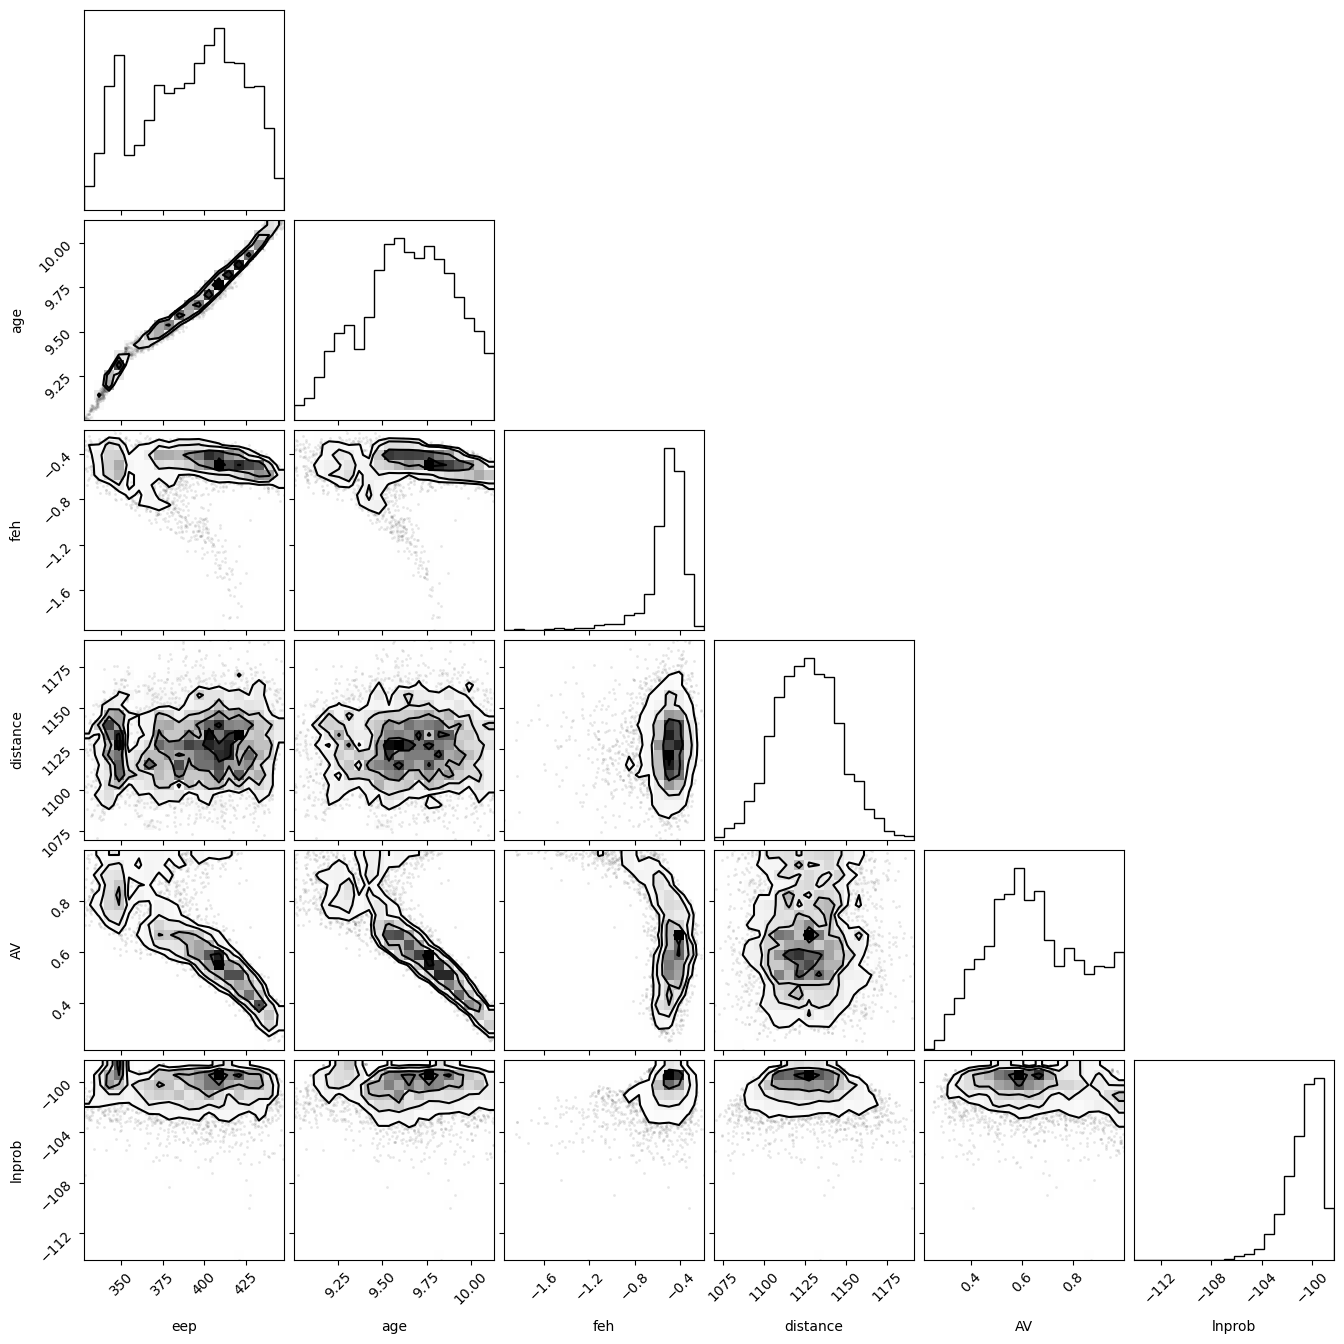

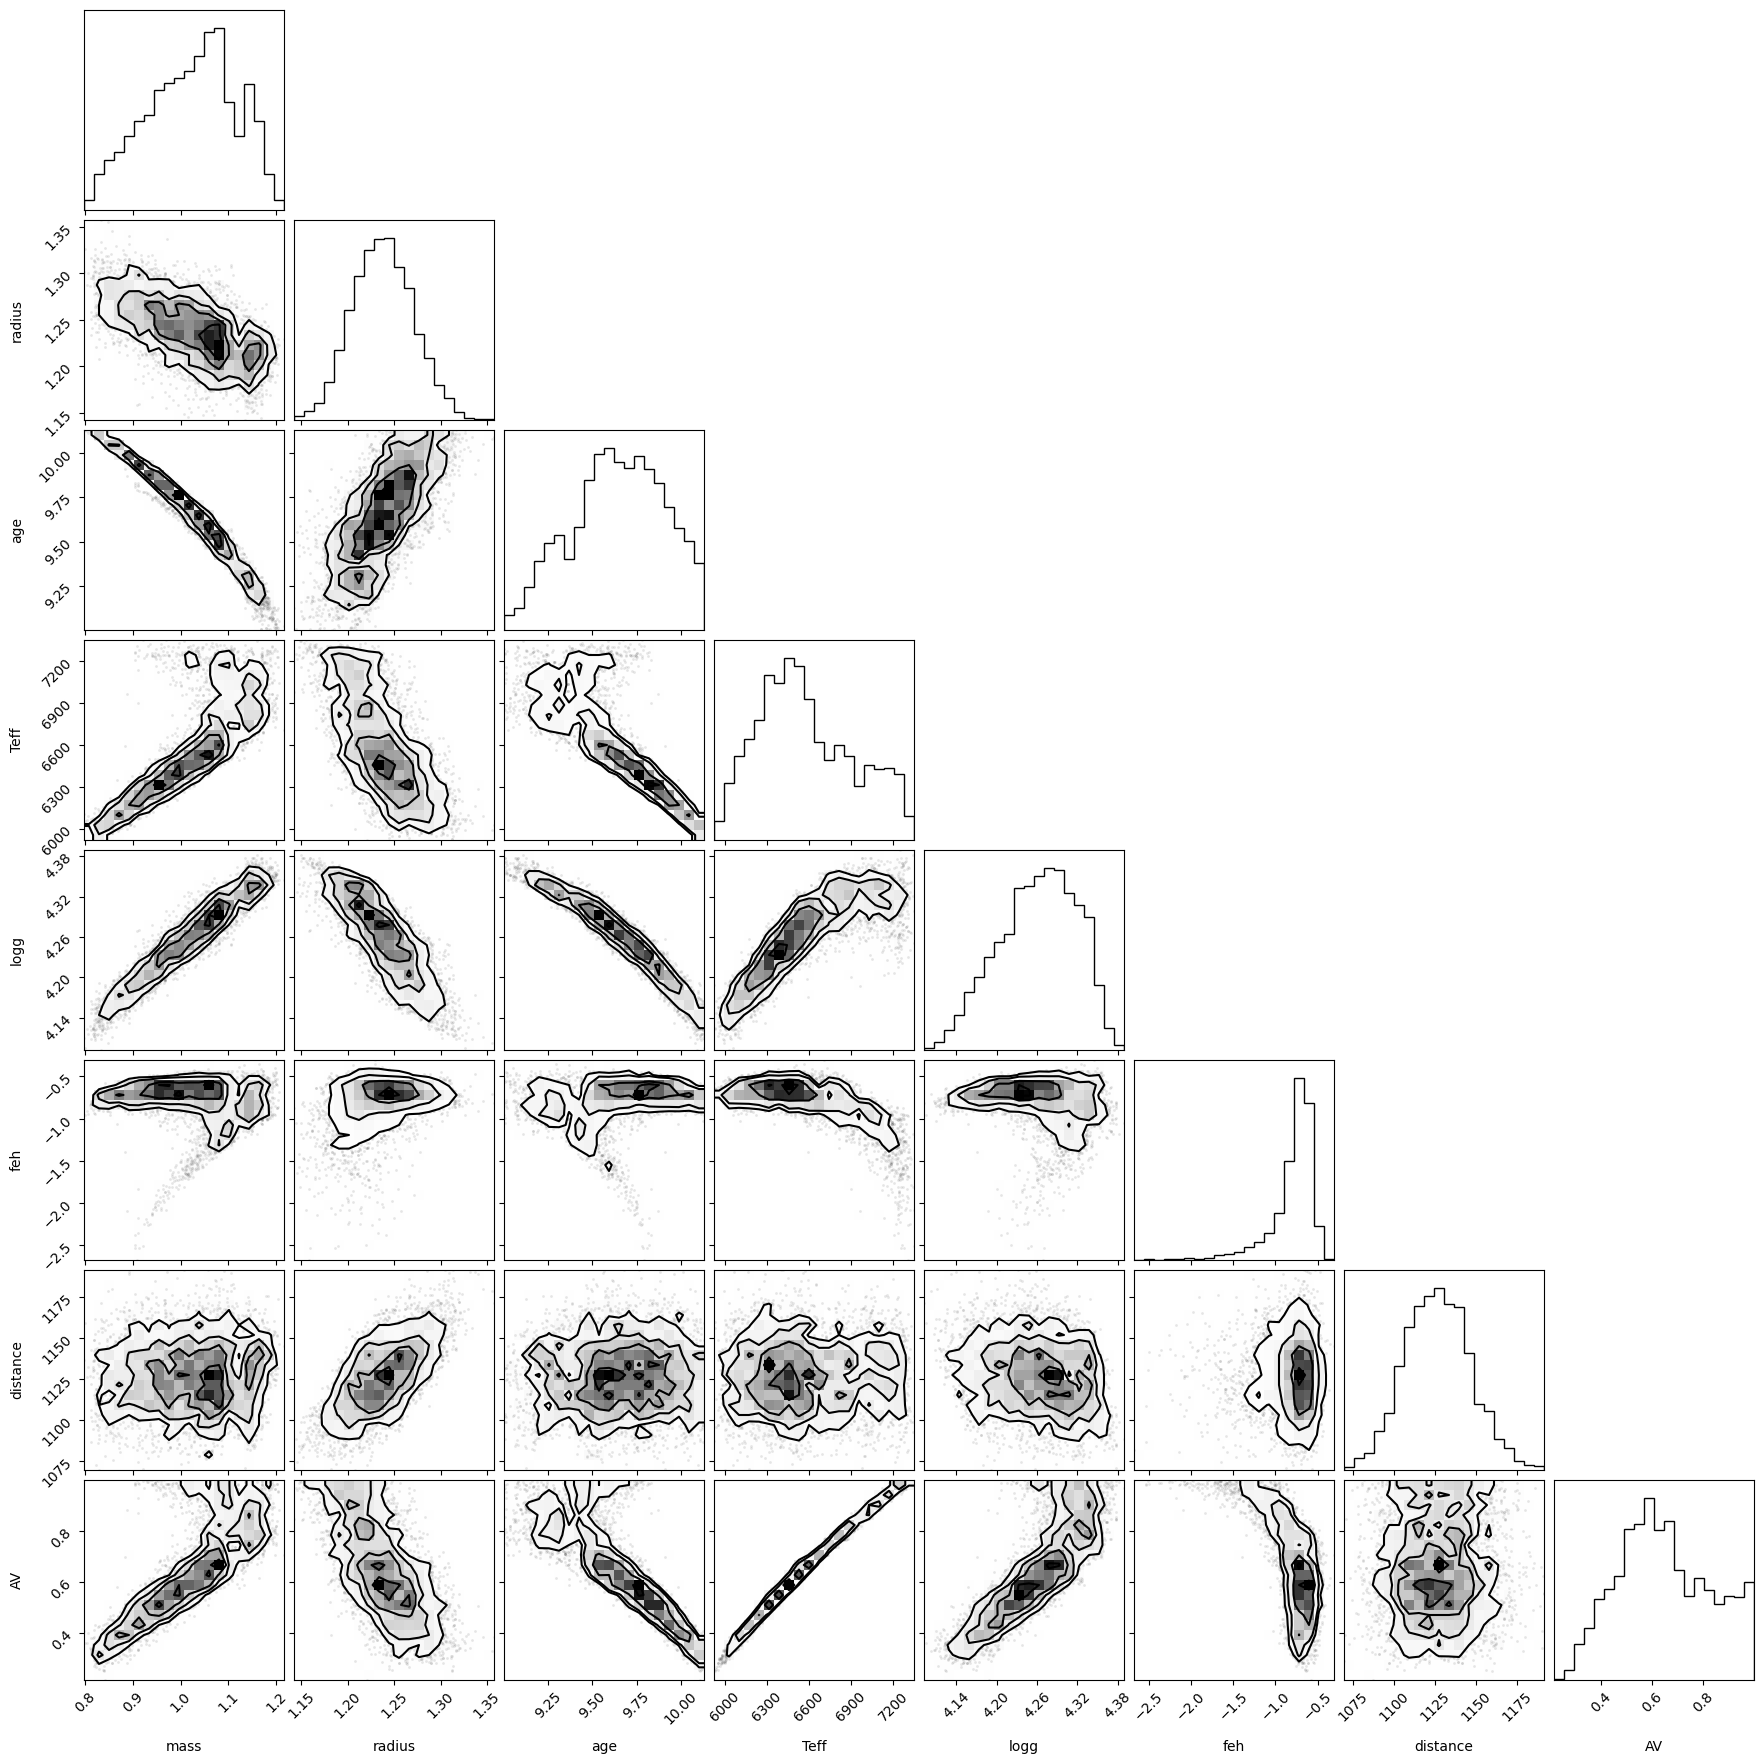

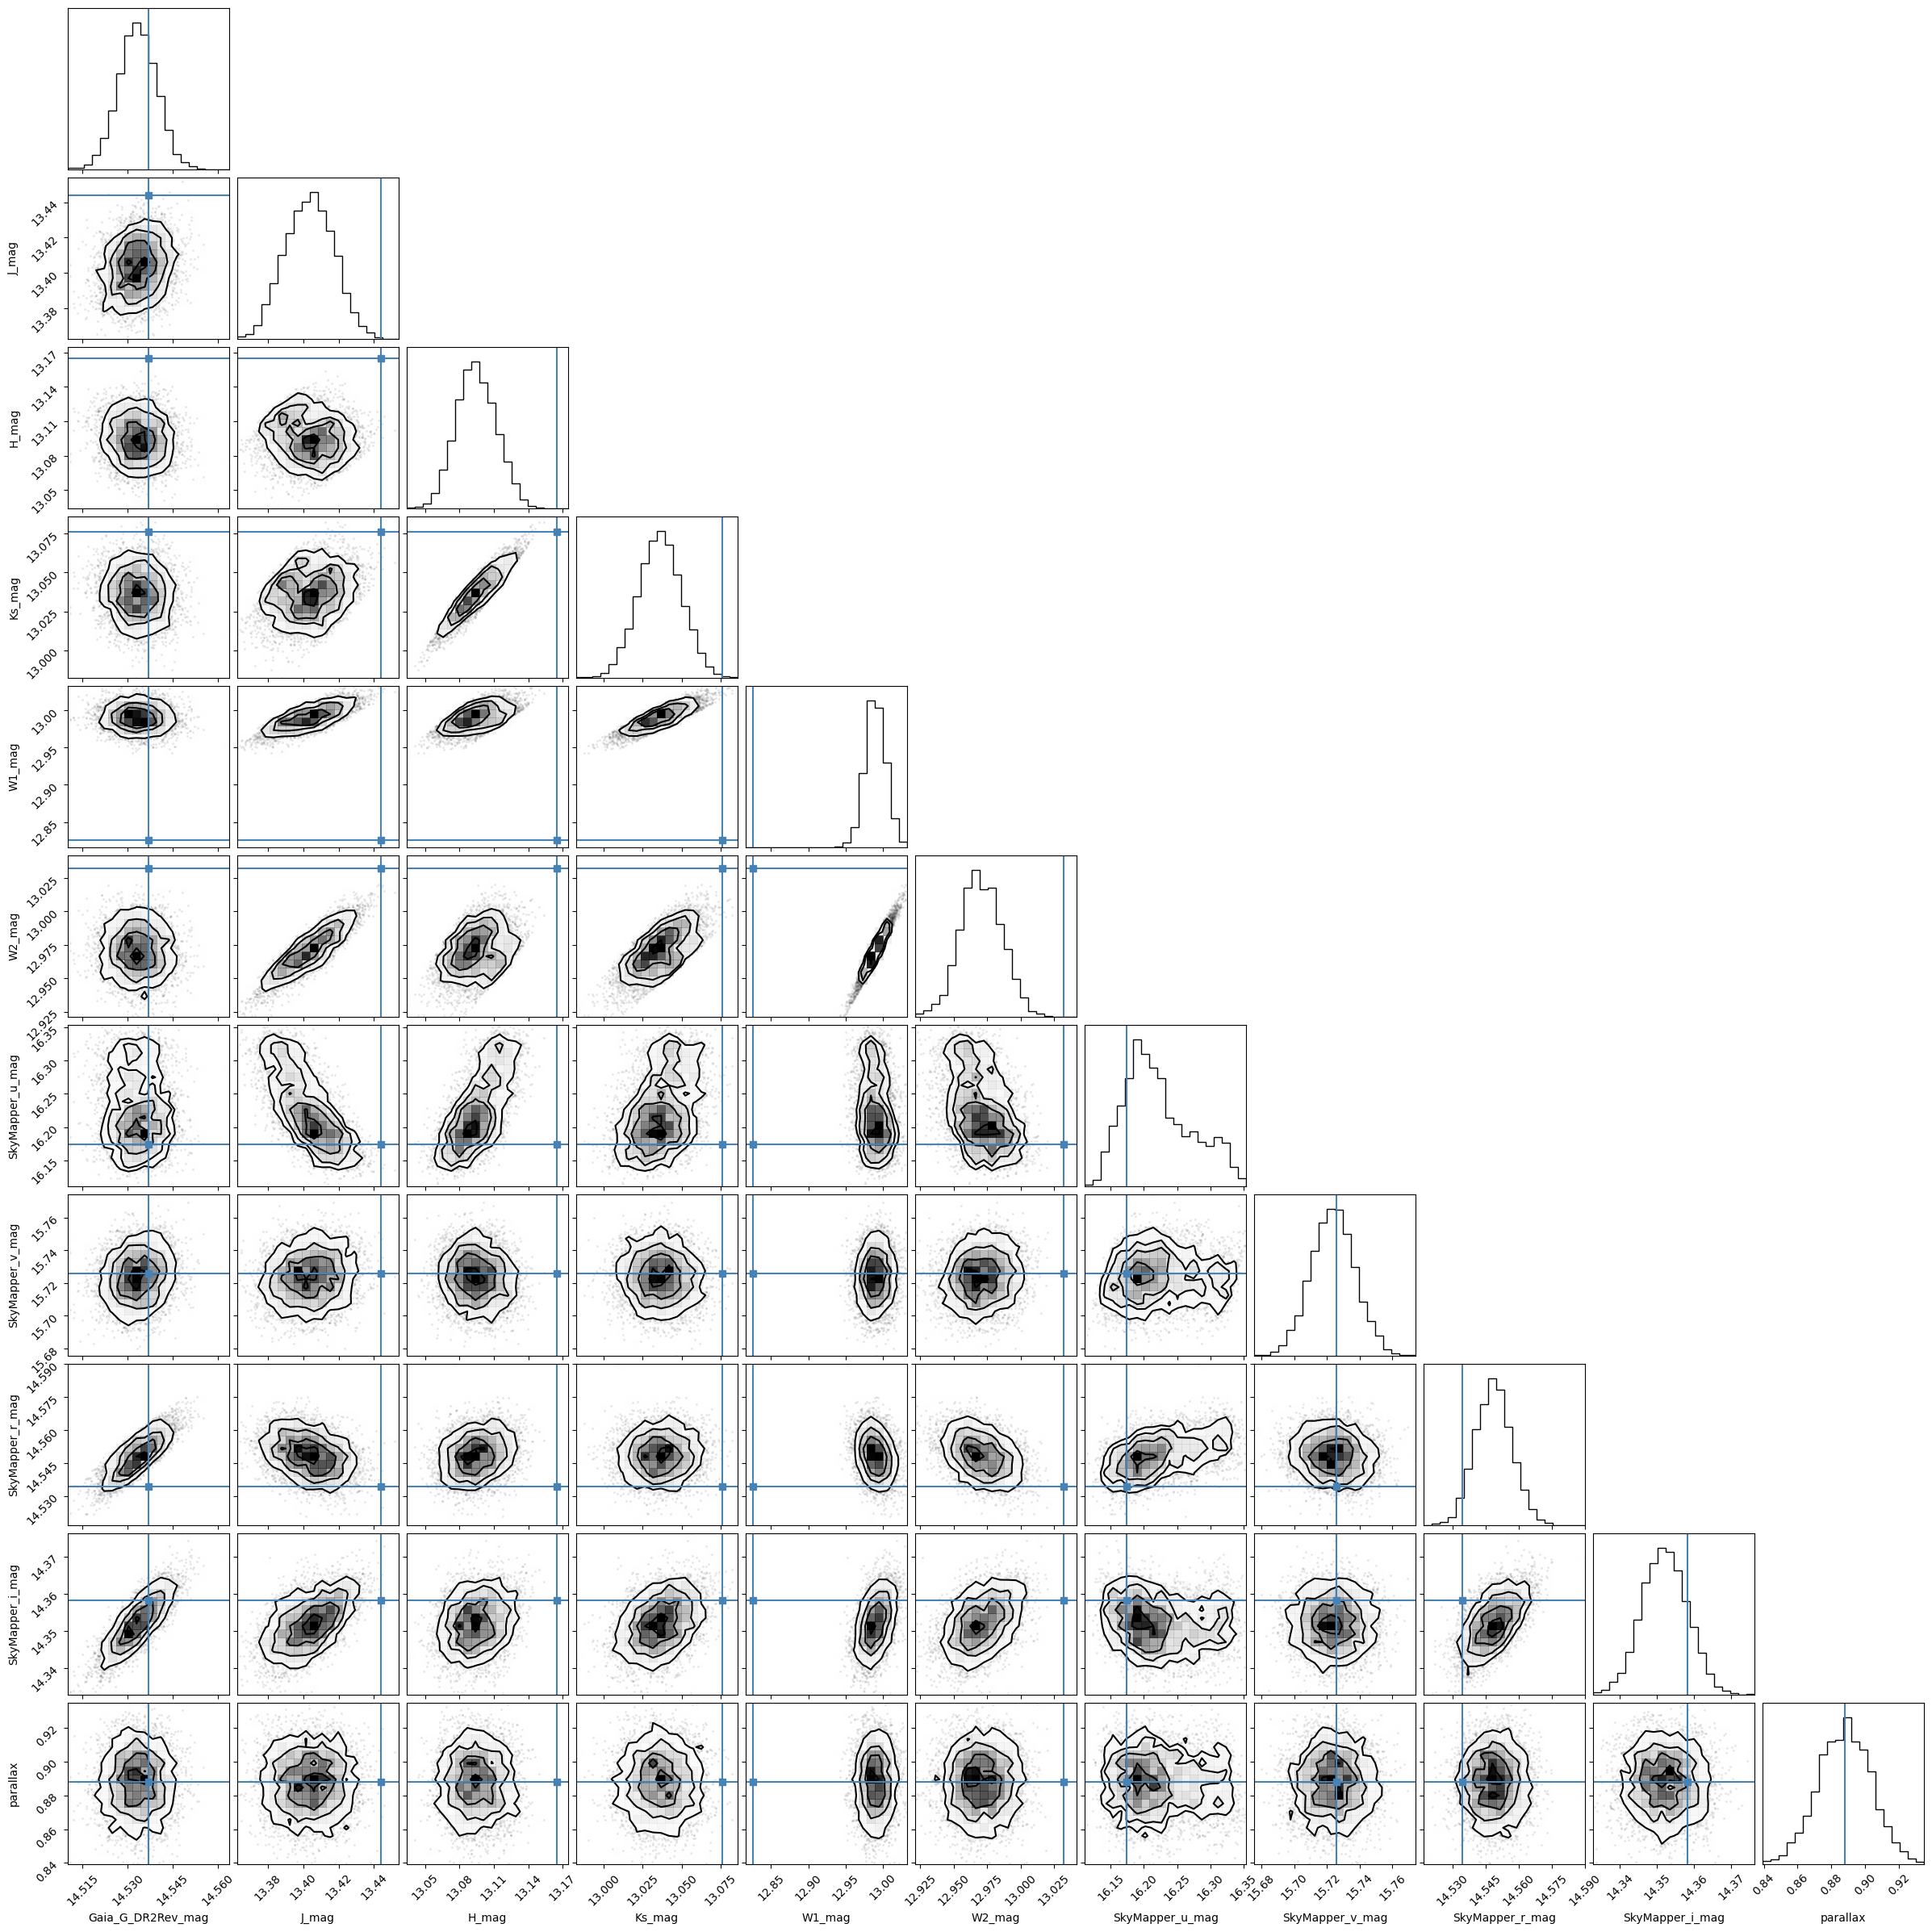

In [17]:
%%time



stars = 0
for i1 in range(np.size(Sample)):
    i2 = Sample['dr3_source_id'][i1]
    filename = String + "{}.csv".format(i2)
    filename2 = String + "samples_{}.csv".format(i2)
    bands = ['Gaia_G_DR2Rev','Gaia_BP_DR2Rev','Gaia_RP_DR2Rev','J','H','Ks','W1','W2','W3','W4',\
             'SDSS_u','SDSS_g','SDSS_r','SDSS_i','SDSS_z',\
             'SkyMapper_u','SkyMapper_v','SkyMapper_g','SkyMapper_r','SkyMapper_i','SkyMapper_z',\
             'PS_g','PS_r','PS_i','PS_z','PS_y',\
             'GALEX_NUV','GALEX_FUV']
    if (Sample['AVclass'][i1]<=2):
        params_iso = {'parallax':(Sample['parallax'][i1]-Sample['zpt'][i1],Sample['parallax_error'][i1]),\
                      'AV':(Sample['AV'][i1],Sample['SigmaAV'][i1])}
    elif  (Sample['AVclass'][i1]==3):
        params_iso = {'parallax':(Sample['parallax'][i1]-Sample['zpt'][i1],Sample['parallax_error'][i1])}
    elif  (Sample['AVclass'][i1]==4):
        params_iso = {'parallax':(Sample['plx_cluster'][i1],Sample['e_plx_cluster'][i1]),\
                      'AV':(Sample['AV'][i1],Sample['SigmaAV'][i1])}
    mags_iso = {'Gaia_G_DR2Rev':(Sample['dr2_gmag'][i1],Sample['e_gmag_dr2'][i1])}
    mags_iso['J']=(Sample['j_m'][i1], Sample['j_msigcom'][i1])
    mags_iso['H']=(Sample['h_m'][i1], Sample['h_msigcom'][i1])
    mags_iso['Ks']=(Sample['k_m'][i1], Sample['k_msigcom'][i1])
    mags_iso['W1']=(Sample['w1mpro'][i1], Sample['w1sigmpro'][i1])
    mags_iso['W2']=(Sample['w2mpro'][i1], Sample['w2sigmpro'][i1])
    if (Sample['uSDSSpass'][i1]>0):
        mags_iso['SDSS_u']=(Sample['psfMag_u'][i1], Sample['psfMagErr_u'][i1])
    if (Sample['gSDSSpass'][i1]>0):
        mags_iso['SDSS_g']=(Sample['psfMag_g'][i1], Sample['psfMagErr_g'][i1])
    if (Sample['rSDSSpass'][i1]>0):
        mags_iso['SDSS_r']=(Sample['psfMag_r'][i1], Sample['psfMagErr_r'][i1])
    if (Sample['iSDSSpass'][i1]>0):
        mags_iso['SDSS_i']=(Sample['psfMag_i'][i1], Sample['psfMagErr_i'][i1])
    if (Sample['zSDSSpass'][i1]>0):
        mags_iso['SDSS_z']=(Sample['psfMag_z'][i1], Sample['psfMagErr_z'][i1])
    if (Sample['uSMpass'][i1]>0):
        mags_iso['SkyMapper_u']=(Sample['u_psf'][i1], Sample['e_u_psf'][i1])
    if (Sample['vSMpass'][i1]>0):
        mags_iso['SkyMapper_v']=(Sample['v_psf'][i1], Sample['e_v_psf'][i1])
    if (Sample['gSMpass'][i1]>0):
        mags_iso['SkyMapper_g']=(Sample['g_psf'][i1], Sample['e_g_psf'][i1])
    if (Sample['rSMpass'][i1]>0):
        mags_iso['SkyMapper_r']=(Sample['r_psf'][i1], Sample['e_r_psf'][i1])
    if (Sample['iSMpass'][i1]>0):
        mags_iso['SkyMapper_i']=(Sample['i_psf'][i1], Sample['e_i_psf'][i1])
    if (Sample['zSMpass'][i1]>0):
        mags_iso['SkyMapper_z']=(Sample['z_psf'][i1], Sample['e_z_psf'][i1])
    if (Sample['BPpass'][i1]>0):
        mags_iso['Gaia_BP_DR2Rev']=(Sample['dr2_bpmag'][i1], Sample['e_bpmag_dr2'][i1])
    if (Sample['RPpass'][i1]>0):
        mags_iso['Gaia_RP_DR2Rev']=(Sample['dr2_rpmag'][i1], Sample['e_rpmag_dr2'][i1])
    if (Sample['PS_gpass'][i1]>0):
        mags_iso['PS_g']=(Sample['gMeanPSFMag'][i1], Sample['gMeanPSFMagErr'][i1])
    if (Sample['PS_rpass'][i1]>0):
        mags_iso['PS_r']=(Sample['rMeanPSFMag'][i1], Sample['rMeanPSFMagErr'][i1])
    if (Sample['PS_ipass'][i1]>0):
        mags_iso['PS_i']=(Sample['iMeanPSFMag'][i1], Sample['iMeanPSFMagErr'][i1])
    if (Sample['PS_zpass'][i1]>0):
        mags_iso['PS_z']=(Sample['zMeanPSFMag'][i1], Sample['zMeanPSFMagErr'][i1])
    if (Sample['PS_ypass'][i1]>0):
        mags_iso['PS_y']=(Sample['yMeanPSFMag'][i1], Sample['yMeanPSFMagErr'][i1])
    if (Sample['NUVpass'][i1]>0):
        mags_iso['GALEX_NUV']=(Sample['NUVmag'][i1], Sample['e_NUVmag'][i1])
    print(i1,Sample['dr3_source_id'][i1],mags_iso,params_iso)
    if (3>2):
        mist = get_ichrone('mist', basic=False, bands=bands)
        model1 = SingleStarModel(mist, **params_iso, **mags_iso)
        model1.set_prior(feh=FlatPrior((-2, 0.50)))
        model1._bounds['feh'] = (-2.0,0.50)
        Inflator = 0.01*0.01
        LowerExtinction = Sample['AV'][i1] -3*np.sqrt(Sample['SigmaAV'][i1]*Sample['SigmaAV'][i1]+Inflator )
        LowerExtinction=np.max([LowerExtinction,0])
        UpperExtinction = Sample['AV'][i1]+3*np.sqrt(Sample['SigmaAV'][i1]*Sample['SigmaAV'][i1]+Inflator )
        model1.set_prior(AV=FlatPrior((LowerExtinction, UpperExtinction)))
        model1._bounds['AV'] = (LowerExtinction, UpperExtinction)
        if (Sample['AVclass'][i1]<=3):
            LowDistance = 1000/(Sample['parallax'][i1]-Sample['zpt'][i1]+3*Sample['parallax_error'][i1])
            HighDistance = 1000/(Sample['parallax'][i1]-Sample['zpt'][i1]-3*Sample['parallax_error'][i1])
            model1._bounds['distance'] = (LowDistance,HighDistance)
        else:
            LowDistance = 1000/(Sample['plx_cluster'][i1]+3*Sample['e_plx_cluster'][i1])
            HighDistance = 1000/(Sample['parallax'][i1]-3*Sample['e_plx_cluster'][i1])
            model1._bounds['distance'] = (LowDistance,HighDistance)
        model1._bounds['age'] = (np.log10(1.0e9),np.log10(13.721e9))
        model1._bounds['mass'] = (0.70,2.0)
        model1.fit(refit=True,n_live_points=LP_Parameter,evidence_tolerance=ET_Parameter,basename=basestring,verbose=False);
        model1.derived_samples.to_csv(filename)
        model1.samples.to_csv(filename2)
        if (1>2):
            figure = model1.corner_params();
            filename3 = String + "PosteriorStar_Physical_{}.pdf".format(i1)
            figure2.savefig(filename3, overwrite=True)
            figure3 = model1.corner_observed();
            filename4 = String + "PosteriorStar_Observed_{}.pdf".format(i1) 
            figure3.savefig(filename4, overwrite=True)
            filename5 = String + "PosteriorStar_{}.pdf".format(i1)
            figure.savefig(filename5, overwrite=True)    
            figure5 = model1.corner_physical();
        clear_output(wait=True)


        